In [185]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

## Functions...

Процент выбросов слева / справа от boxplot 

In [186]:
def outliers_percents(col):
    
        length = len(col)
    
        Q1 = np.nanpercentile(col, 25)
        Q3 = np.nanpercentile(col, 75)
        IQR = Q3 - Q1
        
        
        num_outliers_left = len(col[col < Q1 - 1.5 * IQR]) / length
        num_oulliers_right = len(col[col > Q3 + 1.5 * IQR]) / length
        
        return num_outliers_left, num_oulliers_right

Boxplots subplot

In [187]:
def histplots_info(data):
    
    for col in list(data.columns.values):
        
        sns.histplot(data[col], kde=True);

        num_percent = data[col].isnull().sum() / len(data) * 100
        plt.title(col+" | missing values: {}%".format(round(num_percent, 2)))
        plt.show()

Histplots subplots

In [188]:
def boxplots_info(data):
  
    for col in list(data.columns.values):

        sns.boxplot(data=data[col], orient='h');
        
        outliers_left, outliers_right = outliers_percents(data[col])
        plt.title("Left Outliers : {}% ".format(round(outliers_left * 100, 3))+
                           "| Right Outliers : {}%".format(round(outliers_right * 100, 3)))
        plt.show()

IQR outliers handling

In [189]:
def remove_outliers_iqr(data, columns):
    
#     print(columns)
    
    for col in columns:
    
        Q1 = np.nanpercentile(data[col], 25)
        Q3 = np.nanpercentile(data[col], 75)
        IQR = Q3 - Q1
        
        data.loc[data[col] < Q1 - 1.5 * IQR, col] = Q1 - 1.5 * IQR
        data.loc[data[col] > Q3 + 1.5 * IQR, col] = Q3 + 1.5 * IQR
        

Missing values dealing

In [190]:

def impute(data, columns, how):
    
    if how=='mean':
        for col in columns:
            data[col].fillna(data[col].mean(), inplace=True)
    elif how=='mode':
        for col in columns:
            data[col].fillna(data[col].mode()[0], inplace=True)
    else:
        print('Хз как ?? ')

Other

In [191]:
# loan_amt = train_num['LoanAmount']

# values = [0, 100, 200, 400, 700]
# labels = ['Low', 'Medium', 'High', 'Very High']

# result = pd.cut(loan_amt, bins=values, labels=labels)
# result.value_counts()

# dict_freq = train_cat['Property_Area'].value_counts(normalize=True)

# train_cat['Property_Area'].map(dict_freq)

# train_cat['Loan_Status'].map({'Y': 1, 'N': 0})
# train_cat

# pd.get_dummies(train['Property_Area'])

## Importing part

In [192]:
train = pd.read_csv('train_ctrUa4K.csv')
test = pd.read_csv('test_lAUu6dG.csv')
sample_submission = pd.read_csv('sample_submission_49d68Cx.csv')

target = train['Loan_Status']
train['Loan_Status'] = train['Loan_Status'].map({'Y':0, 'N':1})
# train.drop(['Loan_Status'], axis=1, inplace=True)

idx = len(train)

In [193]:
train_num = train.select_dtypes(np.number)
test_num = test.select_dtypes(np.number)
num = pd.concat([train_num, test_num], axis=0).reset_index(drop=True)

train_cat = train.select_dtypes(include='object')
test_cat = test.select_dtypes(include='object')
cat = pd.concat([train_cat, test_cat], axis=0).reset_index(drop=True)

**Feature Importances**

In [194]:
def IV_index(data, col, condition, to_print=False):

    loan_status_under_condition = data['Loan_Status'][data[col] == condition]

    if to_print:
      print(loan_status_under_condition.value_counts())

    count_good, count_bad = loan_status_under_condition.value_counts().values
    count_all_good, count_all_bad = data['Loan_Status'].value_counts().values

    p, q = count_good / count_all_good, count_bad / count_all_bad 

    return (p - q) * np.log(p / q)

## Numeric features

In [195]:
train_num_tr = train_num.copy()

In [196]:
train_cat_tr = train_cat.copy()

+ **Разберёмся со сроком кредита(фичи-категории). Сначала выполним импутинг модой.**

In [197]:
train_num_tr['Loan_Amount_Term'] = train_num_tr['Loan_Amount_Term'].fillna(train_num_tr['Loan_Amount_Term'].mode()[0])

In [198]:
train_num_tr['Group_Loan_Amount_Term'] = train_num_tr['Loan_Amount_Term'].copy()

train_num_tr['Group_Loan_Amount_Term'] = train_num_tr['Group_Loan_Amount_Term'].replace([12.0, 36.0, 60.0, 84.0, 120.0], '<= 10 years')
train_num_tr['Group_Loan_Amount_Term'] = train_num_tr['Group_Loan_Amount_Term'].replace(180.0, '15 years')
train_num_tr['Group_Loan_Amount_Term'] = train_num_tr['Group_Loan_Amount_Term'].replace(360.0, '30 years')
train_num_tr['Group_Loan_Amount_Term'] = train_num_tr['Group_Loan_Amount_Term'].replace([240.0, 300.0], 'Not beautiful dates')
train_num_tr['Group_Loan_Amount_Term'] = train_num_tr['Group_Loan_Amount_Term'].replace([480.0], '40 years')

Глянем значимость каждой категории

In [199]:
total = 0
for cat in train_num_tr['Group_Loan_Amount_Term'].unique():
  
  total = total + IV_index(train_num_tr, 'Group_Loan_Amount_Term', cat)
  print(cat, IV_index(train_num_tr, 'Group_Loan_Amount_Term', cat))

  # total = total + IV_index(train_num_tr, 'Group_Loan_Amount_Term', cat)

print("\nTotal IV-index:", total)

30 years 0.002033446522989255
<= 10 years 0.0017739100039107472
Not beautiful dates 0.0009401799237747363
15 years 0.0012062772339117092
40 years 0.0037910254548732822

Total IV-index: 0.00974483913945973


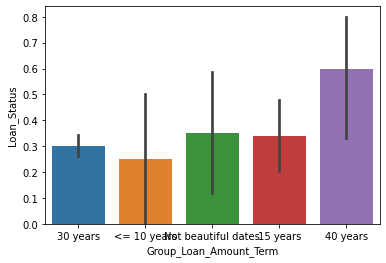

In [200]:
sns.barplot(x='Group_Loan_Amount_Term', y='Loan_Status', data=train_num_tr)

Фичи не информативные (!) 

Должно быть >= 0.02

UPD: По графику, 40 - хороший признак. Но там мало наблюдений

+ **Посчитаем чистый уровень дохода в зависимости от места жительства**

**Urban** - 0.35

**Semiurban** - 0.3

**Rural** - 0.3


Интуитивно, часть зарплаты, которую платят люди за комуналку 

Пока не будем считать средний доход по семье.

In [201]:
train_num_tr['Utility_Bills'] = train_cat_tr['Property_Area'].map({'Urban': 0.35, 'Semiurban': 0.3, 'Rural': 0.3})
train_num_tr['Disposable_Income'] = train_num_tr['ApplicantIncome'] * (1 - train_num_tr['Utility_Bills'])

Заполним LoanAmount средним

In [202]:
train_num_tr['LoanAmount'] = train_num_tr['LoanAmount'].fillna(train_num_tr['LoanAmount'].mean())

Посчитаем сколько надо платить людям надо в месяц

In [203]:
train_num_tr['Monthly_Loan_Amount'] = train_num_tr['LoanAmount'] * 1000 / train_num_tr['Loan_Amount_Term']
train_num_tr['Stable_Difference'] = train_num_tr['Disposable_Income'] - 2 * train_num_tr['Monthly_Loan_Amount']

bins = [-16000, 1420, 2206, 3464, 67000]
labels = ['Low', 'Stable', 'High', 'Very High']

train_num_tr['Stable_Difference_Flag'] = pd.cut(train_num_tr['Stable_Difference'], labels=labels, bins=bins)

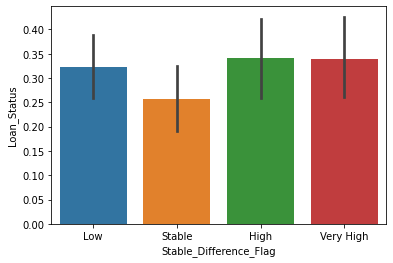

In [204]:
sns.barplot(x='Stable_Difference_Flag', y='Loan_Status', data=train_num_tr)

In [205]:
total = 0
for cat in train_num_tr['Stable_Difference_Flag'].unique():
  print(cat, IV_index(train_num_tr, 'Stable_Difference_Flag', cat)) 
  total = total + IV_index(train_num_tr, 'Stable_Difference_Flag', cat)

total

High 0.0036574939204469165
Stable 0.018396096305548053
Low 0.0008010143400619673
Very High 0.002771415512576325


0.025626020078633262

Никакой разницы. Посчитаем Adjusted


UPD: сумма даёт >= 0.02

In [206]:
train_cat_tr['Dependents'] = train_cat_tr['Dependents'].fillna(train_cat_tr['Dependents'].mode()[0])
train_cat_tr['Married'] = train_cat_tr['Married'].fillna(train_cat_tr['Married'].mode()[0])

train_num_tr['Dependents'] = train_cat_tr['Dependents'].map({'0': 0, '1': 1, '2': 2, "3+": 3.5})
train_num_tr['Married'] = train_cat_tr['Married'].map({'Yes': 1, 'No': 0})

In [207]:
train_num_tr['Dependents'] = train_cat_tr['Dependents'].map({'0': 0, '1': 1, '2': 2, "3+": 3.5})
train_num_tr['Married'] = train_cat_tr['Married'].map({'Yes': 1, 'No': 0})


train_num_tr['Adjusted_Disposable_Income'] = (train_num_tr['ApplicantIncome'] + 
                                    train_num_tr['CoapplicantIncome']) / (1 + train_num_tr['Dependents'] + train_num_tr['Dependents']) * (1 - train_num_tr['Utility_Bills'])

train_num_tr['Adjusted_Stable_Difference'] = train_num_tr['Adjusted_Disposable_Income'] - 2 * train_num_tr['Monthly_Loan_Amount']


train_num_tr.describe()

bins = [-16000, 200, 1870, 3200, 67000]
labels = ['Low', 'Stable', 'High', 'Very High']

train_num_tr['Adjusted_Stable_Difference_Flag'] = pd.cut(train_num_tr['Adjusted_Stable_Difference'], labels=labels, bins=bins)

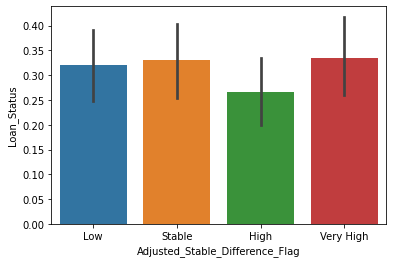

In [208]:
sns.barplot(x='Adjusted_Stable_Difference_Flag', y='Loan_Status', data=train_num_tr)

In [209]:
total = 0
for cat in train_num_tr['Adjusted_Stable_Difference_Flag'].unique():
  print(cat, IV_index(train_num_tr, 'Adjusted_Stable_Difference_Flag', cat))

  total = total + IV_index(train_num_tr, 'Adjusted_Stable_Difference_Flag', cat)

total

High 0.012355663705878045
Stable 0.0018232017677984153
Low 0.00030616770455684384
Very High 0.0026521519964230805


0.017137185174656386

Опять херовые фичи

UPD: одна норм есть :) Но это уже будут Extreme_Adjusted (20%)

UPD2: уже нету

URD3: тут выигрыша нет

In [210]:
train_num_tr['Extreme_Adjusted_Stable_Difference'] = train_num_tr['Adjusted_Disposable_Income'] - 4 * train_num_tr['Monthly_Loan_Amount']

train_num_tr.describe()

bins = [-100000, -900, 1000, 2000, 100000]
labels = ['Low', 'Stable', 'High', 'Very High']

train_num_tr['Extreme_Adjusted_Stable_Difference_Flag'] = pd.cut(train_num_tr['Extreme_Adjusted_Stable_Difference'], labels=labels, bins=bins)

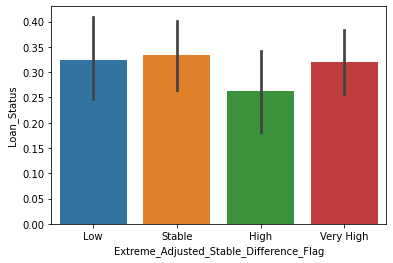

In [211]:
sns.barplot(x='Extreme_Adjusted_Stable_Difference_Flag', y='Loan_Status', data=train_num_tr)

In [212]:
total = 0
for cat in train_num_tr['Extreme_Adjusted_Stable_Difference_Flag'].unique():
  print(cat, IV_index(train_num_tr, 'Extreme_Adjusted_Stable_Difference_Flag', cat))

  total = total + IV_index(train_num_tr, 'Extreme_Adjusted_Stable_Difference_Flag', cat)

total

Very High 0.0004261408731418075
Stable 0.0026110943815049257
High 0.01205725734889272
Low 0.0004523654983891529


0.015546858101928606

Плохо. Как я так сумел сгенерить ?

+ **Влияние аутлаеров**

In [213]:
for col in ['ApplicantIncome', 'LoanAmount']:

      Q1 = np.nanpercentile(train_num_tr[col], 25)
      Q3 = np.nanpercentile(train_num_tr[col], 75)
      IQR = Q3 - Q1
      
      train_num_tr['{}_Outliers'.format(col)] = train_num_tr[col].map(lambda x: 'Normal' if x <= Q3 + 1.5 * IQR else 'Outlier') 
      # # temp[col > Q3 + 1.5 * IQR].groupby(col).mean()['Loan_Status']
      # print(temp[temp[col] > Q3 + 1.5 * IQR]['Loan_Status'].mean())

train_num_tr['CoapplicantIncome_Outliers'] = train_num_tr['CoapplicantIncome'].map(lambda x: 'Normal' if x <= 6700 else 'Outlier')

In [214]:
for col in ['ApplicantIncome_Outliers', 'CoapplicantIncome_Outliers', 'LoanAmount_Outliers']:
  for cat in train_num_tr[col].unique():
    print(cat, IV_index(train_num_tr, col, cat, 1))

    

0    389
1    175
Name: Loan_Status, dtype: int64
Normal 0.00011670014318542844
0    33
1    17
Name: Loan_Status, dtype: int64
Outlier 0.0012847153585739493
0    414
1    185
Name: Loan_Status, dtype: int64
Normal 0.0003150213906442646
0    8
1    7
Name: Loan_Status, dtype: int64
Outlier 0.01144527032763252
0    397
1    176
Name: Loan_Status, dtype: int64
Normal 0.0006249932709673457
0    25
1    16
Name: Loan_Status, dtype: int64
Outlier 0.008220613428976481


Тоже всё плохо

Отдельно гляну **ApplicantIncome**

In [215]:
bins = [0, 2600, 4400, 8300, 100000]
labels = ['Low', 'Stable', 'High', 'Very High']

train_num_tr['ApplicantIncome_Flag'] = pd.cut(train_num_tr['ApplicantIncome'], labels=labels, bins=bins)

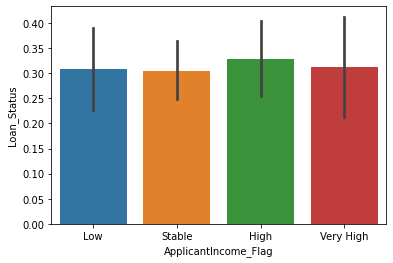

In [216]:
sns.barplot(x='ApplicantIncome_Flag', y='Loan_Status', data=train_num_tr)

In [217]:
total
for cat in train_num_tr['ApplicantIncome_Flag'].unique():
  print(cat, IV_index(train_num_tr, 'ApplicantIncome_Flag', cat, 1))

  total = total + IV_index(train_num_tr, 'ApplicantIncome_Flag', cat)

total

0    108
1     53
Name: Loan_Status, dtype: int64
High 0.0015223035687067581
0    174
1     76
Name: Loan_Status, dtype: int64
Stable 0.0006729469614568128
0    85
1    38
Name: Loan_Status, dtype: int64
Low 6.153317474598788e-05
0    55
1    25
Name: Loan_Status, dtype: int64
Very High 1.1693058304206961e-07


0.01780375873742121

Полная ерунда, что просто по бинам, что по точной статистике

Последний вздох, попробуем разбивать по 10

**Обычный стабильный заработок**

In [218]:
labels = ['1','2','3','4','5','6','7','8','9','10']

train_num_tr['Stable_Difference_Flag_10'] = pd.qcut(train_num_tr['Stable_Difference'], labels=labels, q=10)

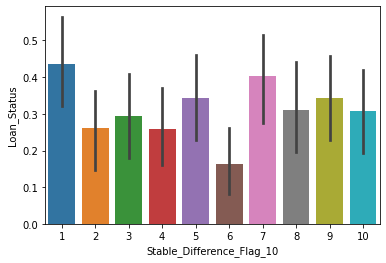

In [219]:
sns.barplot(x='Stable_Difference_Flag_10', y='Loan_Status', data=train_num_tr)

In [220]:
total = 0
for cat in train_num_tr['Stable_Difference_Flag_10'].unique():
  print(cat, IV_index(train_num_tr, 'Stable_Difference_Flag_10', cat, to_print=0)) 

  total = total + IV_index(train_num_tr, 'Stable_Difference_Flag_10', cat)

total

8 3.2478286310240797e-06
7 0.016819488369917358
4 0.006893869508558626
2 0.005745365602613033
6 0.05788560044563661
3 0.0006786897020740836
5 0.0020883535505546703
10 8.592249574812709e-05
1 0.030458458496855047
9 0.0020883535505546703


0.12274734955114326

Вот это уже хорошо!

**Посчитаем Adjusted**

In [221]:
labels = ['1','2','3','4','5','6','7','8','9','10']

train_num_tr['Adjusted_Stable_Difference_Flag_10'] = pd.qcut(train_num_tr['Adjusted_Stable_Difference'], labels=labels, q=10)

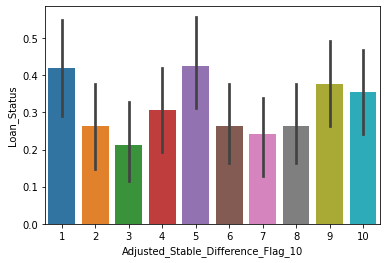

In [222]:
sns.barplot(x='Adjusted_Stable_Difference_Flag_10', y='Loan_Status', data=train_num_tr)

In [223]:
total = 0
for cat in train_num_tr['Adjusted_Stable_Difference_Flag_10'].unique():
  print(cat, IV_index(train_num_tr, 'Adjusted_Stable_Difference_Flag_10', cat))

  total = total + IV_index(train_num_tr, 'Adjusted_Stable_Difference_Flag_10', cat)

total

8 0.005745365602613033
4 8.592249574812709e-05
5 0.025727917600135135
7 0.011789822934777
1 0.02315456431167091
6 0.005745365602613033
2 0.005745365602613033
9 0.008489550944022713
3 0.023880659849726038
10 0.0037548800080122718


0.11411941495193129

Это очень хорошо!

**Экстрим фичи**

In [224]:
labels = ['1','2','3','4','5','6','7','8','9','10']

train_num_tr['Extreme_Adjusted_Stable_Difference_Flag_10'] = pd.qcut(train_num_tr['Extreme_Adjusted_Stable_Difference'], labels=labels, q=10)

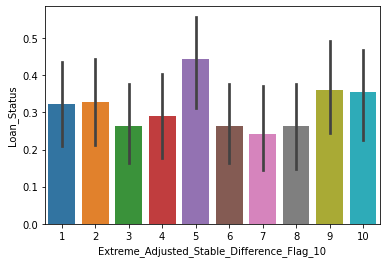

In [225]:
sns.barplot(x='Extreme_Adjusted_Stable_Difference_Flag_10', y='Loan_Status', data=train_num_tr)

In [226]:
total = 0
for cat in train_num_tr['Extreme_Adjusted_Stable_Difference_Flag_10'].unique():
  print(cat, IV_index(train_num_tr, 'Extreme_Adjusted_Stable_Difference_Flag_10', cat, to_print=False))

  total = total + IV_index(train_num_tr, 'Extreme_Adjusted_Stable_Difference_Flag_10', cat)

total

8 0.005745365602613033
4 0.001117870751626851
5 0.0334505239806338
7 0.011789822934777
1 0.0002114842093311701
6 0.005745365602613033
2 0.0004884064542764472
3 0.005745365602613033
9 0.004765543365292652
10 0.0037548800080122718


0.0728146285117893

Результаты лучше чем, по 4 категории. Вместо 4 буду использовать разбиение на 10 !

## Categorical features

In [227]:
train_cat_tr = pd.concat([train_cat_tr, target.map({'Y':0, 'N':1})], axis=1)

In [228]:
# train_cat_tr.drop(['Loan_Status'], axis=1, inplace=True)

### Смотрим известные

**Gender**

In [229]:
train_cat_tr['Gender'] = train_cat_tr['Gender'].fillna(train_cat_tr['Gender'].mode()[0])

In [230]:
total = 0
for cat in train_cat_tr['Gender'].unique():
  print(cat)
  print(cat, IV_index(train_cat_tr, 'Gender', cat, to_print=True))
  
  total = total + IV_index(train_cat_tr, 'Gender', cat)

total

Male
0    347
1    155
Name: Loan_Status, dtype: int64
Male 0.0002755371410635144
Female
0    75
1    37
Name: Loan_Status, dtype: int64
Female 0.0012127375310401758


0.0014882746721036901

Не информативненько, хотя и предсказуемо

**Married**

In [231]:
train_cat_tr['Married'] = train_cat_tr['Married'].fillna(train_cat_tr['Married'].mode()[0])

In [232]:
for cat in train_cat_tr['Married'].unique():
  print(cat)
  print(cat, IV_index(train_cat_tr, 'Married', cat, to_print=True))

No
0    134
1     79
Name: Loan_Status, dtype: int64
No 0.024337084546927203
Yes
0    288
1    113
Name: Loan_Status, dtype: int64
Yes 0.013906463452199426


О, это уже хорошо

**Dependents**

In [233]:
train_cat_tr['Dependents'] = train_cat_tr['Dependents'].fillna(train_cat_tr['Dependents'].mode()[0])

In [234]:
for cat in train_cat_tr['Dependents'].unique():
  print(cat)
  print(cat, IV_index(train_cat_tr, 'Dependents', cat, to_print=True))

0
0    247
1    113
Name: Loan_Status, dtype: int64
0 1.7815327708574132e-05
1
0    66
1    36
Name: Loan_Status, dtype: int64
1 0.005641079542648411
2
0    76
1    25
Name: Loan_Status, dtype: int64
2 0.016180550105188776
3+
0    33
1    18
Name: Loan_Status, dtype: int64
3+ 0.0028205397713242054


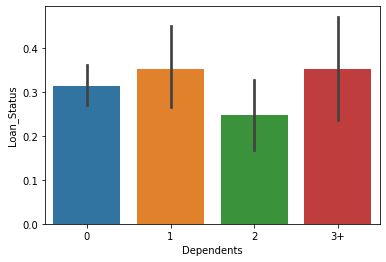

In [235]:
sns.barplot(x='Dependents', y='Loan_Status', data=train_cat_tr)

Пока никак

**Education**

In [236]:
train_cat_tr['Education'] = train_cat_tr['Education'].fillna(train_cat_tr['Education'].mode()[0])

In [237]:
for cat in train_cat_tr['Education'].unique():
  print(cat)
  print(cat, IV_index(train_cat_tr, 'Education', cat, to_print=True))

Graduate
0    340
1    140
Name: Loan_Status, dtype: int64
Graduate 0.007636233320430611
Not Graduate
0    82
1    52
Name: Loan_Status, dtype: int64
Not Graduate 0.025407451651578622


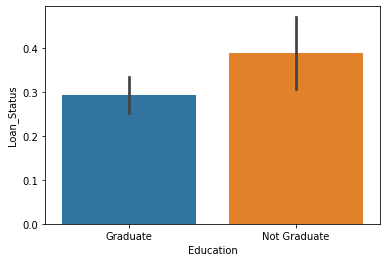

In [238]:
sns.barplot(x='Education', y='Loan_Status', data=train_cat_tr)

**Self-Employed**

In [239]:
train_cat_tr['Self_Employed'] = train_cat_tr['Self_Employed'].fillna(train_cat_tr['Self_Employed'].mode()[0])

In [240]:
for cat in train_cat_tr['Self_Employed'].unique():
  print(cat)
  print(cat, IV_index(train_cat_tr, 'Self_Employed', cat, to_print=True))

No
0    366
1    166
Name: Loan_Status, dtype: int64
No 8.51393004604037e-06
Yes
0    56
1    26
Name: Loan_Status, dtype: int64
Yes 5.499671263827754e-05


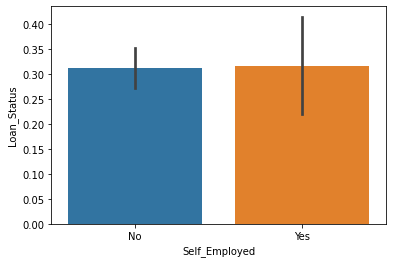

In [241]:
sns.barplot(x='Self_Employed', y='Loan_Status', data=train_cat_tr)

Не оч хорошая фича

**Property Area**

In [242]:
train_cat_tr['Property_Area'] = train_cat_tr['Property_Area'].fillna(train_cat_tr['Property_Area'].mode()[0])

In [243]:
for cat in train_cat_tr['Property_Area'].unique():
  print(cat)
  print(cat, IV_index(train_cat_tr, 'Property_Area', cat, to_print=True))

Urban
0    133
1     69
Name: Loan_Status, dtype: int64
Urban 0.005803213053546384
Rural
0    110
1     69
Name: Loan_Status, dtype: int64
Rural 0.031699821958221755
Semiurban
0    179
1     54
Name: Loan_Status, dtype: int64
Semiurban 0.058724911680074286


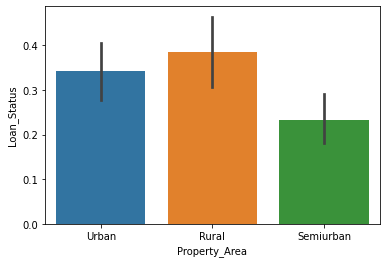

In [244]:
sns.barplot(x='Property_Area', y='Loan_Status', data=train_cat_tr)

Опа, хорошие фичи!

### Теперь свои

#### "Женатая фича"

**Женатые без детей**

In [245]:
for cat in train_cat_tr['Gender'].unique():
  print(cat)
  print(cat, IV_index(train_cat_tr[(train_cat_tr['Married'] == 'Yes') & (train_cat_tr['Dependents'] == '0')], 'Gender', cat, to_print=True))


Male
0    120
1     44
Name: Loan_Status, dtype: int64
Male 8.933631869778867e-05
Female
0    15
1     6
Name: Loan_Status, dtype: int64
Female 0.0006840981434322519


По гендеру никакой разницы!

**Неженатые люди без детей**

In [246]:
for cat in train_cat_tr['Gender'].unique():
  print(cat)
  print(cat, IV_index(train_cat_tr[(train_cat_tr['Married'] == 'No') & (train_cat_tr['Dependents'] == '0')], 'Gender', cat, to_print=True))

Male
0    71
1    42
Name: Loan_Status, dtype: int64
Male 0.001648490320243341
Female
0    41
1    21
Name: Loan_Status, dtype: int64
Female 0.003067084300150456


Тоже никакой разницы

**Разведенные люди (неженаты, но с детьми)** 

In [247]:
for cat in train_cat_tr['Gender'].unique():
  print(cat)
  print(cat, IV_index(train_cat_tr[(train_cat_tr['Married'] == 'No') & (train_cat_tr['Dependents'] != '0')], 'Gender', cat, to_print=True))

Male
0    12
1     8
Name: Loan_Status, dtype: int64
Male 0.00395506259043771
Female
0    10
1     8
Name: Loan_Status, dtype: int64
Female 0.004332280900196587


Их просто мало, но там примерно 50/50

**Женаты и с детьми (по гендеру)**

In [248]:
for cat in train_cat_tr['Gender'].unique():
  print(cat)
  print(cat, IV_index(train_cat_tr[(train_cat_tr['Married'] == 'Yes') & (train_cat_tr['Dependents'] != '0')], 'Gender', cat, to_print=True))

Male
0    144
1     61
Name: Loan_Status, dtype: int64
Male 0.0007680196343120363
Female
0    9
1    2
Name: Loan_Status, dtype: int64
Female 0.016700702008856927


Для мужиков никакой разницы, женщин мало (там 4:1 почти)

**Просто женаты (по детям)**

In [249]:
for cat in train_cat_tr['Dependents'].unique():
  print(cat)
  print(cat, IV_index(train_cat_tr[(train_cat_tr['Married'] == 'Yes')], 'Dependents', cat, to_print=True))

0
0    135
1     50
Name: Loan_Status, dtype: int64
0 0.0015153527656898242
1
0    53
1    26
Name: Loan_Status, dtype: int64
1 0.010288918127874727
2
0    71
1    22
Name: Loan_Status, dtype: int64
2 0.012237010015105645
3+
0    29
1    15
Name: Loan_Status, dtype: int64
3+ 0.00885598251408964


Для 3+ примерно 3:1, остальное - мусор

UPD: Эта по сумме IV хороша

Вывод: сами по себе эти признаки - мусор. С них надо нагенерить одну "женатую" фичу, независимо от результатов тут. Например по статье.

In [250]:
def family_ball(col):
  
  ball = 0

  if (col['Married'] != 'Yes') & (col['Dependents'] == '0'):
    ball += 17.29
  
  if (col['Married'] != 'Yes') & (col['Dependents'] != '0'):
    ball += 5.53

  if (col['Married'] != 'No') & (col['Dependents'] == '0'):
    ball += 8.83
  
  if (col['Married'] != 'No') & (col['Dependents'] != '0'):
    ball += -19.86


  return ball

fb = [family_ball(train_cat_tr.iloc[i]) for i in range(len(train_cat_tr))]
train_cat_tr['Family_Ball'] = fb
train_cat_tr.corr()

,Loan_Status,Family_Ball
Loan_Status,1.000000,0.041635
Family_Ball,0.041635,1.000000


In [251]:
for cat in train_cat_tr['Family_Ball'].unique():

  print(cat, IV_index(train_cat_tr, 'Family_Ball', cat, to_print=True))

0    112
1     63
Name: Loan_Status, dtype: int64
17.29 0.013306241865199494
0    153
1     63
Name: Loan_Status, dtype: int64
-19.86 0.003436304994193776
0    135
1     50
Name: Loan_Status, dtype: int64
8.83 0.012239282501850003
0    22
1    16
Name: Loan_Status, dtype: int64
5.53 0.014634850181787501


Хорошая фича

Попробуем предсказать **Возраст**

In [252]:
train_cat_tr['ApplicantIncome_Flag'] = train_num_tr['ApplicantIncome_Flag'].copy()

In [253]:
def age(col):
  
  ball = 0

  if (col['Dependents'] == 0):
    ball += 10.00
  elif (col['Dependents'] == 1):
    ball += 25.00
  elif (col['Dependents'] == 2):
    ball += 35.00
  else:
    ball += 45.00
  
  if (col['Married'] == 'Yes'):
    ball += 15
  else:
    ball += -25

  if (col['Property_Area'] == 'Urban'):
    ball += -5

  if (col['Self_Employed'] == 'Yes'):
    ball += 8

  if (col['ApplicantIncome_Flag'] == 'Low') | (col['ApplicantIncome_Flag'] == 'Stable'):
    ball += +10
  elif (col['ApplicantIncome_Flag'] == 'High'):
    ball += -10
  else:
    ball += -15

  return ball

age = [age(train_cat_tr.iloc[i]) for i in range(len(train_cat_tr))]
train_cat_tr['Age'] = age
train_cat_tr.corr()

,Loan_Status,Family_Ball,Age
Loan_Status,1.000000,0.041635,-0.094149
Family_Ball,0.041635,1.000000,-0.535795
Age,-0.094149,-0.535795,1.000000


In [ ]:
total = 0
for cat in train_cat_tr['Age'].unique():

  print(cat, IV_index(train_cat_tr, 'Age', cat, to_print=False))

  total += IV_index(train_cat_tr, 'Age', cat, to_print=False)

total

In [255]:
labels = ['1','2','3','4','5']
# labels = ['1','2','3','4','5','6','7','8','9','10']

train_cat_tr['Age_Flag'] = pd.qcut(train_cat_tr['Age'], labels=labels, q=5)

In [ ]:
total = 0
for cat in train_cat_tr['Age_Flag'].unique():

  print(cat, IV_index(train_cat_tr, 'Age_Flag', cat, to_print=False))

  total += IV_index(train_cat_tr, 'Age_Flag', cat, to_print=False)

total

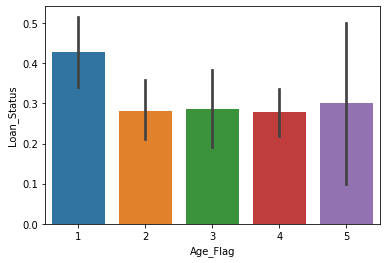

In [257]:
sns.barplot(x='Age_Flag', y='Loan_Status', data=train_cat_tr)

Попробуем предсказать **Статус**

In [258]:
# train_num_tr
# Adjusted_Disposable_Income	

In [259]:
train_cat_tr['CoapplicantIncome_Outliers'] = train_num_tr['CoapplicantIncome_Outliers'].copy()
train_cat_tr['ApplicantIncome_Outliers'] = train_num_tr['ApplicantIncome_Outliers'].copy()
train_cat_tr['LoanAmount_Outliers'] = train_num_tr['LoanAmount_Outliers'].copy()

train_cat_tr['Adjusted_Stable_Difference_Flag'] = train_num_tr['Adjusted_Stable_Difference_Flag'].copy()

In [ ]:
def status(col):
  
  ball = 0

  if (col['Dependents'] == 0):
    ball += 1.00
  elif (col['Dependents'] == 1):
    ball += 1.00
  elif (col['Dependents'] == 2):
    ball += 2.00
  else:
    ball += 2.00
  
  if (col['Married'] == 'Yes'):
    ball += 2
  else:
    ball += 0

  if (col['Property_Area'] == 'Urban'):
    ball += 1.5

  if (col['Education'] == 'Graduate'):
    ball += 2
  else:
    ball -= 2


  if (col['ApplicantIncome_Flag'] == 'Low') | (col['ApplicantIncome_Flag'] == 'Stable'):
    ball += -2
  elif (col['ApplicantIncome_Flag'] == 'High'):
    ball += +2
  else:
    ball += +3

  if (col['ApplicantIncome_Flag'] == 'Low') | (col['ApplicantIncome_Flag'] == 'Stable'):
    ball += -2
  elif (col['ApplicantIncome_Flag'] == 'High'):
    ball += +2
  else:
    ball += +3
  
  if (col['ApplicantIncome_Outliers'] == 'Outlier') | (col['CoapplicantIncome_Outliers'] == 'Outlier') | (col['LoanAmount_Outliers'] == 'Outlier'):
    ball += 3

  if (col['Adjusted_Stable_Difference_Flag'] == 'High') | (col['Adjusted_Stable_Difference_Flag'] == 'Very High'):
    ball += 4
  elif (col['Adjusted_Stable_Difference_Flag'] == 'Stable'):
     ball += 2
  else:
    ball += -2

  return ball

status = [status(train_cat_tr.iloc[i]) for i in range(len(train_cat_tr))]
train_cat_tr['Status'] = status
train_cat_tr.corr()

In [261]:
labels = ['1','2','3']
# labels = ['1','2','3','4','5','6','7','8','9','10']

train_cat_tr['Status_Flag'] = pd.qcut(train_cat_tr['Status'], labels=labels, q=3)

In [ ]:
total = 0
for cat in train_cat_tr['Status_Flag'].unique():

  print(cat, IV_index(train_cat_tr, 'Status_Flag', cat, to_print=True))

  total += IV_index(train_cat_tr, 'Status_Flag', cat, to_print=False)

total

In [ ]:
sns.barplot(x='Status_Flag', y='Loan_Status', data=train_cat_tr)

Неплохо

**Балл за возраст**

In [ ]:
def age_ball(col):
  
  ball = 0

  if (col['Age_Flag'] == '1') | (col['Age_Flag'] != '2'):
    ball += 12.51

  if (col['Age_Flag'] == '3') | (col['Age_Flag'] != '4'):
    ball += 5.28

  if (col['Age_Flag'] == '5'):
    ball += 37.16
  
  return ball

ab = [age_ball(train_cat_tr.iloc[i]) for i in range(len(train_cat_tr))]
train_cat_tr['Age_Ball'] = ab
train_cat_tr.corr()

Годная фича

Подоходная фича 

In [265]:
# ApplicantIncome_Flag

In [ ]:
def monthly_income_ball(col):
  
  ball = 0

  if (col['ApplicantIncome_Flag'] == 'Low'):
    ball += 67.84
  else:
    ball += 72.19

  return ball

mib = [monthly_income_ball(train_cat_tr.iloc[i]) for i in range(len(train_cat_tr))]
train_cat_tr['Monthly_Income_Ball'] = mib
train_cat_tr.corr()

Cтоп-фактор фича 

In [ ]:
def stop_factor_ball(col):
  
  ball = 0

  if (col['ApplicantIncome_Outliers'] == 'Normal') & (col['CoapplicantIncome_Outliers'] == 'Normal') & (col['LoanAmount_Outliers'] == 'Normal'):
    ball += 34.56

  return ball

sfb = [stop_factor_ball(train_cat_tr.iloc[i]) for i in range(len(train_cat_tr))]
train_cat_tr['Stop_Factor_Ball'] = sfb
train_cat_tr.corr()

Кредитный рейтинг фича 

In [277]:
train_cat_tr['Credit_History'] = train_num_tr['Credit_History'].copy()

In [ ]:
def credit_history_ball(col):
  
  ball = 0

  if (col['Credit_History'] == 1):
    ball += 50 #если ставить 70 - очень большая корреляция с Credit_History
  elif (col['Credit_History'] == 0):
    ball += -5.23
  else: 
    ball += 26.67


  return ball

chb = [credit_history_ball(train_cat_tr.iloc[i]) for i in range(len(train_cat_tr))]
train_cat_tr['Credit_History_Ball'] = chb
train_cat_tr.corr()

Образование фича 

In [ ]:
def education_ball(col):
  
  ball = 0

  if (col['Education'] == 'Graduate'):
    ball += 35.46
  else:
    ball += -17.47


  return ball

eb = [education_ball(train_cat_tr.iloc[i]) for i in range(len(train_cat_tr))]
train_cat_tr['Education_Ball'] = eb
train_cat_tr.corr()

In [ ]:
def is_woman_ball(col):
  
  ball = 0

  if (col['Gender'] == 'Female'):
    ball += 23.76


  return ball

iwb = [is_woman_ball(train_cat_tr.iloc[i]) for i in range(len(train_cat_tr))]
train_cat_tr['Is_Woman_Ball'] = iwb
train_cat_tr.corr()

In [306]:
def final_ball(col):
  
  ball = 0

  ball += col['Family_Ball']
  ball += col['Age_Ball']
  ball += col['Monthly_Income_Ball']
  ball += col['Stop_Factor_Ball']
  ball += col['Credit_History_Ball']
  ball += col['Education_Ball']
  ball += col['Is_Woman_Ball']

  return ball

final_b = [final_ball(train_cat_tr.iloc[i]) for i in range(len(train_cat_tr))]
train_cat_tr['Final_Ball'] = final_b
train_cat_tr.corr()

,Loan_Status,Family_Ball,Age,Status,Age_Ball,Monthly_Income_Ball,Stop_Factor_Ball,Credit_History,Credit_History_Ball,Education_Ball,Is_Woman_Ball,Final_Ball
Loan_Status,1.000000,0.041635,-0.094149,-0.020866,0.034683,0.004060,-0.041602,-0.561678,-0.522383,-0.085884,0.017987,-0.295081
Family_Ball,0.041635,1.000000,-0.535795,0.105751,-0.090992,-0.091648,0.068279,0.013975,0.013588,0.032925,0.276321,0.489515
Age,-0.094149,-0.535795,1.000000,-0.337197,0.155485,-0.204417,0.207405,-0.010259,-0.019199,-0.103304,-0.280040,-0.262632
Status,-0.020866,0.105751,-0.337197,1.000000,-0.002971,0.294286,-0.553778,0.060340,0.058860,0.460273,-0.063406,0.165497
Age_Ball,0.034683,-0.090992,0.155485,-0.002971,1.000000,-0.072197,0.059502,-0.023073,-0.020272,0.018721,-0.091268,0.185372
Monthly_Income_Ball,0.004060,-0.091648,-0.204417,0.294286,-0.072197,1.000000,-0.128092,-0.006312,0.000102,0.109907,-0.048085,0.003815
Stop_Factor_Ball,-0.041602,0.068279,0.207405,-0.553778,0.059502,-0.128092,1.000000,-0.000680,0.002026,-0.164356,0.026049,0.243968
Credit_History,-0.561678,0.013975,-0.010259,0.060340,-0.023073,-0.006312,-0.000680,1.000000,1.000000,0.081822,-0.013472,0.556092
Credit_History_Ball,-0.522383,0.013588,-0.019199,0.058860,-0.020272,0.000102,0.002026,1.000000,1.000000,0.082421,-0.018431,0.548529
Education_Ball,-0.085884,0.032925,-0.103304,0.460273,0.018721,0.109907,-0.164356,0.081822,0.082421,1.000000,0.045364,0.587083


Момент истины

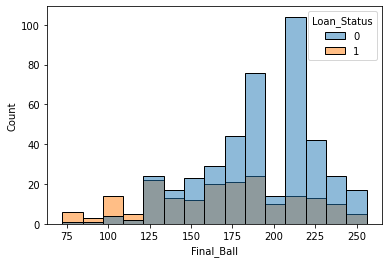

In [307]:
sns.histplot(data=train_cat_tr, x='Final_Ball', hue='Loan_Status')

In [308]:
# train_cat_tr.drop(['Salary_Ball'], axis=1, inplace=True)

In [309]:
# labels = ['1','2','3']
labels = ['1','2','3','4','5','6','7','8','9','10']

train_cat_tr['Final_Ball_Flag'] = pd.qcut(train_cat_tr['Final_Ball'], labels=labels, q=10)

In [310]:
total = 0
for cat in train_cat_tr['Final_Ball_Flag'].unique():

  print(cat, IV_index(train_cat_tr, 'Final_Ball_Flag', cat, to_print=False))

  total += IV_index(train_cat_tr, 'Final_Ball_Flag', cat, to_print=False)

total

9 0.007686943350279902
6 0.008637186016384697
10 0.007544891162260126
3 0.0020883535505546703
1 0.0022997998738483565
5 0.04203909729434747
2 0.01170667583963601
4 0.0021901090926606534
7 0.08305418735139657
8 0.14010206992417762


0.30734931345554606

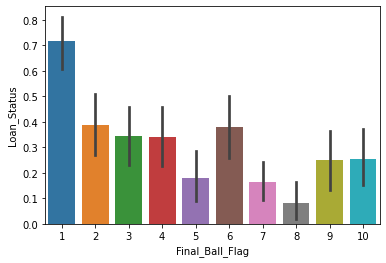

In [305]:
sns.barplot(x='Final_Ball_Flag', y='Loan_Status', data=train_cat_tr)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,Property_Area,Loan_Status,Family_Ball,ApplicantIncome_Flag,Age,Age_Flag,CoapplicantIncome_Outliers,ApplicantIncome_Outliers,LoanAmount_Outliers,Adjusted_Stable_Difference_Flag,Status,Status_Flag


Время генерить фичи! 

Посмотрим насколько они хороши

Предлагаю сначала заполнить нули, и удалить выбросы в нужных для нас колонках. **Пока только для тренировочного** 

In [ ]:
cat.columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'Property_Area'],
      dtype='object')

In [ ]:
for col in ['Gender', 'Married', 'Dependents', 'Education',
            'Self_Employed', 'Property_Area']:
  impute(train_cat, cat, 'mode')

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [ ]:
cat_dummies = pd.DataFrame()
for col in ['Gender', 'Married', 'Dependents', 'Education',
            'Self_Employed', 'Property_Area']:
  cat_dummies = pd.concat([cat_dummies, pd.get_dummies(data=train_cat[col], drop_first=True, prefix=col)], axis=1)

In [ ]:
cat_dummies = pd.concat([cat_dummies, target.map({'Y': 0, 'N': 1})], axis=1)

Заполяняем средним в **Loan Amount**

In [ ]:
train_num['LoanAmount'] = train_num['LoanAmount'].fillna(train_num['LoanAmount'].mean())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


**Cначала Loan Term Imputation**. Потом будет больше инфы для более сильной **Credit History** 

** **спойлер**: ничего не вышло. Не хочу тратить на это время. Все классификаторы заполняют модой(360 месяцев)

In [ ]:
train_num['Loan_Amount_Term'] = train_num['Loan_Amount_Term'].fillna(360.0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Заполняем **Credit History**.

In [ ]:
RS=4

ch = train_num['Credit_History']
X_ch = pd.concat([train_num.drop(['Credit_History'], axis=1), cat_dummies], axis=1)

sc = MinMaxScaler()

X_ch = pd.DataFrame(data=sc.fit_transform(X_ch), columns=X_ch.columns)

X_ch['Loan_Amount_Term'] = X_ch['Loan_Amount_Term'].fillna(360.0)
X_ch['LoanAmount'] = X_ch['LoanAmount'].fillna(X_ch['LoanAmount'].mean())

# X_term['Credit_History'] = X_term['Credit_History'].astype('float64')

ch_to_train_test =  ch[~ch.isna()]
ch_to_predict =  ch[ch.isna()]

X_ch_to_train_test =  X_ch[~ch.isna()]
X_ch_to_predict =  X_ch[ch.isna()]


from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report

X_train, X_test, y_train, y_test = train_test_split(X_ch_to_train_test, ch_to_train_test, 
                                                    test_size=0.2, random_state=RS)


knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)


print(knn.score(X_test, y_test))
print(knn.score(X_train, y_train))

print(confusion_matrix(y_test, knn.predict(X_test)))
print(confusion_matrix(y_train, knn.predict(X_train)))

print(classification_report(y_test, knn.predict(X_test)))
print(classification_report(y_train, knn.predict(X_train)))

0.9026548672566371
0.8736141906873615
[[ 9  8]
 [ 3 93]]
[[ 35  37]
 [ 20 359]]
              precision    recall  f1-score   support

         0.0       0.75      0.53      0.62        17
         1.0       0.92      0.97      0.94        96

    accuracy                           0.90       113
   macro avg       0.84      0.75      0.78       113
weighted avg       0.90      0.90      0.90       113

              precision    recall  f1-score   support

         0.0       0.64      0.49      0.55        72
         1.0       0.91      0.95      0.93       379

    accuracy                           0.87       451
   macro avg       0.77      0.72      0.74       451
weighted avg       0.86      0.87      0.87       451



Лучший выбор - KNN(5). Удивительно, но оверфита нет.

In [ ]:
X_ch['Credit_History'] = ch
X_ch['Credit_History'][X_ch['Credit_History'].isna()] = knn.predict(X_ch.drop(['Credit_History'], axis=1))

temp_['Credit_History'] = X_ch['Credit_History']

**Доход в семье на одного человека умножаем на срок дейсвия кредита. Соотносим цифры.**

In [ ]:
# temp_['Dependents'] = temp_['Dependents'].fillna(0)
# temp_['Dependents'] = temp_['Dependents'].replace('3+', 3.5)
# temp_['Dependents'] = temp_['Dependents'].astype('float')

# temp_['Dependents'].value_counts()

In [ ]:
# temp_['Medium_Family_Income'] = (temp['ApplicantIncome'] + temp['CoapplicantIncome']) / (temp_['Dependents'] + 1)

In [ ]:
# sns.histplot(temp_['Medium_Family_Income'])

In [ ]:
# temp_['Stable_Medium_Family_Income'] = temp_['Medium_Family_Income'] * temp['Loan_Amount_Term']

In [ ]:
# temp_['Is_Stable_Medium_Family_Income'] = 0.1*temp_['Stable_Medium_Family_Income'] - (temp['LoanAmount'] * 1000)

In [ ]:
# sns.histplot(temp_['Is_Stable_Medium_Family_Income'])

In [ ]:
# temp_[temp_['Is_Stable_Medium_Family_Income'] <= 0.8*1000000].mean()

Не сработало предположение, проверку "на дурака" проходят все. Ведь тут наивно предполагается, что человек будет стабильно до 40 лет получать одну и ту же зарплату. Нужно перед этим ввести понятие "риска" и использовать в качестве коэфициента.

**Быстро заполним нули в temp_**

In [ ]:
temp_['Group_Loan_Amount_Term'] = temp_['Group_Loan_Amount_Term'].fillna(temp_['Group_Loan_Amount_Term'].mode()[0])
temp_['Group_Loan_Amount_Term'].isnull().sum()

0

**Risk feature**

Family_Risk_Feature

In [ ]:
def family_risk(col):
  
  index = 1

  #Разведённые женщины и просто неженетые люди
  if col['Married'] == 'No':
    index *= 2/3
    if (col['Dependents'] != '0') & (col['Gender'] == 'Female'):
      index *= 1/2

  # #Неженатые мужики 
  # if col['Married'] == 'No':
  #   index *= 2/3
  #   if (col['Dependents'] != '0') & (col['Gender'] == 'Female'):
  #     index *= 1/2


  


  return index

fr = [family_risk(temp_.iloc[i]) for i in range(len(temp_))]
temp_['Family_Risk'] = fr
temp_.corr()

,Loan_Status,Credit_History,Family_Risk,Work_Risk,Family_Work_Mean_Risk,Risk
Loan_Status,1.000000,-0.562034,-0.095780,-0.085884,-0.118465,-0.154660
Credit_History,-0.562034,1.000000,-0.003047,0.081967,0.035785,0.037664
Family_Risk,-0.095780,-0.003047,1.000000,-0.010292,0.739068,0.494161
Work_Risk,-0.085884,0.081967,-0.010292,1.000000,0.624329,0.387311
Family_Work_Mean_Risk,-0.118465,0.035785,0.739068,0.624329,1.000000,0.650295
Risk,-0.154660,0.037664,0.494161,0.387311,0.650295,1.000000


Почти 8%, неплохо

Work_Risk_feature

In [ ]:
def work_risk(col):
  
  index = 1

  if col['Education'] != 'Graduate':
    index *= 2/3
    if col['Self_Employed'] is 'Yes':
      index *= 1/2

  return index

wr = [work_risk(temp_.iloc[i]) for i in range(len(temp_))]
temp_['Work_Risk'] = wr
temp_.corr()

,Loan_Status,Credit_History,Family_Risk,Work_Risk,Family_Work_Mean_Risk,Risk
Loan_Status,1.000000,-0.562034,-0.095780,-0.085884,-0.118465,-0.154660
Credit_History,-0.562034,1.000000,-0.003047,0.081967,0.035785,0.037664
Family_Risk,-0.095780,-0.003047,1.000000,-0.010292,0.739068,0.494161
Work_Risk,-0.085884,0.081967,-0.010292,1.000000,0.624329,0.387311
Family_Work_Mean_Risk,-0.118465,0.035785,0.739068,0.624329,1.000000,0.650295
Risk,-0.154660,0.037664,0.494161,0.387311,0.650295,1.000000


Больше 8%, еще лучше

Ищем среднее

In [ ]:
temp_['Family_Work_Mean_Risk'] = (temp_['Family_Risk'] + temp_['Work_Risk']) / 2
temp_.corr()

,Loan_Status,Credit_History,Family_Risk,Work_Risk,Family_Work_Mean_Risk,Risk
Loan_Status,1.000000,-0.562034,-0.095780,-0.085884,-0.128882,-0.154660
Credit_History,-0.562034,1.000000,-0.003047,0.081967,0.047521,0.037664
Family_Risk,-0.095780,-0.003047,1.000000,-0.010292,0.792839,0.494161
Work_Risk,-0.085884,0.081967,-0.010292,1.000000,0.601239,0.387311
Family_Work_Mean_Risk,-0.128882,0.047521,0.792839,0.601239,1.000000,0.630942
Risk,-0.154660,0.037664,0.494161,0.387311,0.630942,1.000000


Еще лучше, ничего себе 

Делаем индикаторы по аутлаерам и кредит истории

In [ ]:
temp_['LoanAmount_Outliers'] = temp['LoanAmount_Outliers'] 
temp_['ApplicantIncome_Outliers'] = temp['ApplicantIncome_Outliers']
temp_['CoapplicantIncome_Outliers'] = temp['CoapplicantIncome_Outliers']
temp_['Group_Loan_Amount_Term'] = temp['Group_Loan_Amount_Term']

In [ ]:
def risk(col):
  
  index = col['Family_Work_Mean_Risk']

  if col['Group_Loan_Amount_Term'] == '40 years':
    index *= 0.75

  if col['LoanAmount_Outliers'] == 'Outlier':
    index *= 0.5

  if col['Property_Area'] == 'Rural':
    index *= 2/3

  # if col['Credit_History'] == 0:
  #   index *= 0.9

  return index

risk = [risk(temp_.iloc[i]) for i in range(len(temp_))]
temp_['Risk'] = risk
temp_.corr()

,Loan_Status,Credit_History,Family_Risk,Work_Risk,Family_Work_Mean_Risk,Risk
Loan_Status,1.000000,-0.562034,-0.095780,-0.085884,-0.128882,-0.182089
Credit_History,-0.562034,1.000000,-0.003047,0.081967,0.047521,0.045415
Family_Risk,-0.095780,-0.003047,1.000000,-0.010292,0.792839,0.357440
Work_Risk,-0.085884,0.081967,-0.010292,1.000000,0.601239,0.292755
Family_Work_Mean_Risk,-0.128882,0.047521,0.792839,0.601239,1.000000,0.464057
Risk,-0.182089,0.045415,0.357440,0.292755,0.464057,1.000000


Круто, сначала думал, что вообще на 42% нашел фичу, но не совсем. 

Корреляция перетекала из кредитной истории. Если вообще убрать влияние истории - будет не 23, а 15. Это тоже отличный результат! Нагенерил неплохую фичу из ничего. Небольшое влияние истории оставил (домножаю на 0.9)


In [ ]:
temp_.iloc[-10:, :]

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,Property_Area,Group_Loan_Amount_Term,Loan_Status,Credit_History,Family_Risk,Work_Risk,Family_Work_Mean_Risk,LoanAmount_Outliers,ApplicantIncome_Outliers,CoapplicantIncome_Outliers,Risk
604,LP002959,Female,Yes,1,Graduate,No,Semiurban,30 years,0,1.0,1.000000,1.000000,1.000000,Outlier,Outlier,Normal,0.500000
605,LP002960,Male,Yes,0,Not Graduate,No,Urban,15 years,1,1.0,1.000000,0.666667,0.833333,Outlier,Normal,Normal,0.416667
606,LP002961,Male,Yes,1,Graduate,No,Semiurban,30 years,0,1.0,1.000000,1.000000,1.000000,Normal,Normal,Normal,1.000000
607,LP002964,Male,Yes,2,Not Graduate,No,Rural,30 years,0,1.0,1.000000,0.666667,0.833333,Normal,Normal,Normal,0.555556
608,LP002974,Male,Yes,0,Graduate,No,Rural,30 years,0,1.0,1.000000,1.000000,1.000000,Normal,Normal,Normal,0.666667
609,LP002978,Female,No,0,Graduate,No,Rural,30 years,0,1.0,0.666667,1.000000,0.833333,Normal,Normal,Normal,0.555556
610,LP002979,Male,Yes,3+,Graduate,No,Rural,15 years,0,1.0,1.000000,1.000000,1.000000,Normal,Normal,Normal,0.666667
611,LP002983,Male,Yes,1,Graduate,No,Urban,30 years,0,1.0,1.000000,1.000000,1.000000,Normal,Normal,Normal,1.000000
612,LP002984,Male,Yes,2,Graduate,No,Urban,30 years,0,1.0,1.000000,1.000000,1.000000,Normal,Normal,Normal,1.000000
613,LP002990,Female,No,0,Graduate,Yes,Semiurban,30 years,1,0.0,0.666667,1.000000,0.833333,Normal,Normal,Normal,0.833333


Rural непонятный

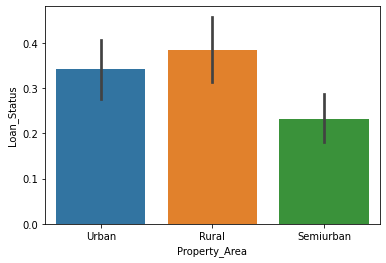

In [ ]:
sns.barplot(x='Property_Area', y='Loan_Status', data=temp_)

А ну посмотрим насколько **риск** хорош

In [ ]:
temp_[temp_['Risk'] <= 0.25]['Loan_Status']

338    1
Name: Loan_Status, dtype: int64

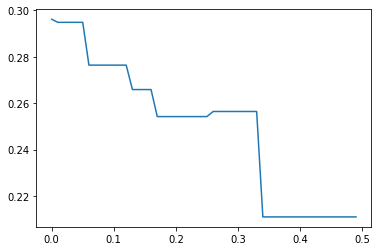

In [ ]:
lst = np.array([temp_[temp_['Risk'] >= 0.5+i]['Loan_Status'].mean() for i in np.arange(0, 0.5, 0.01)])
lst_len = np.array([len(temp_[temp_['Risk'] >= 0.5+i]['Loan_Status']) for i in np.arange(0, 0.5, 0.01)])

plt.plot(np.arange(0, 0.5, 0.01), lst)

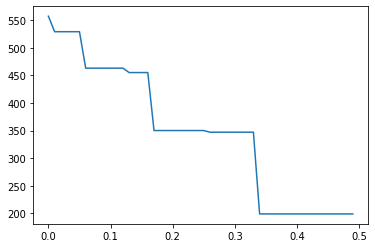

In [ ]:
plt.plot(np.arange(0, 0.5, 0.01), lst_len)